In [1]:
import numpy as np
import scipy.sparse as spsp
import matplotlib.pyplot as plt

In [4]:
def generate_squares2D(N, M):
    I = np.zeros((N+2, M+2))
    I[:N//2+1, :M//2+1] = 80
    I[:N//2+1, -(M//2+1):] = 190
    I[-(N//2+1):, :M//2+1] = 140
    I[-(N//2+1):, -(M//2+1):] = 230
    return I

def add_noise2D(I, scale = 10):
    N, M = I.shape
    N -= 2
    M -= 2
    I[1:-1, 1:-1] += np.random.rand(N,M) * scale
    return I
    
def generate_random2D(N, M, scale = 10):
    I = generate_squares2D(N, M)
    add_noise2D(I)
    return I

In [94]:
M = 1
N = 1
K = (M+2)*(N+2)
dx = 1/(M+1)
dy = 1/(N+1)

I = generate_random2D(N, M, scale = 2)

T = 1000
dt = 1e-3
r = dt/(2*(dx**2+ dy**2))

U = np.zeros((T, K))

g = lambda s: 1/(1+s)

In [131]:
def diffX(M, N, scheme = "central", sparse = False):
    K = (M+2)*(N+2)
    Dx = np.zeros((K, K))
    dx = 1/(M+1)
    
    if scheme == "central":
        Bx = (-1 * np.eye(M+2, k = -1) + np.eye(M+2, k = 1))
        Bx[0, :3] = [-3, 4, -1]
        Bx[-1, -3:] = [1, -4, 3]
        Bx /= (2*dx)
        
    elif scheme == "forward":
        Bx = (-1 * np.eye(M+2) + np.eye(M+2, k = 1))
        Bx[-1, -2:] = [-1, 1]
        Bx /= dx
    else:
        raise Exception("Invalid scheme in Dx")    
        
    for i in range(N+2):
        Dx[i*(M+2):(i+1)*(M+2), i*(M+2):(i+1)*(M+2)] = Bx
    
    if sparse:
        return spsp.csr_matrix(Dx)
    return Dx

diffX(M, N, sparse = True)

<484x484 sparse matrix of type '<class 'numpy.float64'>'
	with 1012 stored elements in Compressed Sparse Row format>

In [132]:
def diffY(M, N, scheme = "central", sparse = False):
    K = (M+2)*(N+2)
    Dy = np.zeros((K, K))
    dy = 1/(N+1)
    
    if scheme == "central":
        Dy = -np.eye(K, k = -(M+2)) + np.eye(K, k = M+2)
        Dy[:(M+2), :3*(M+2)] = np.hstack((-3*np.identity(M+2), 4*np.identity(M+2), -np.identity(M+2)))
        Dy[-(M+2):, -3*(M+2):] = np.hstack((np.identity(M+2), -4*np.identity(M+2), 3*np.identity(M+2)))
        Dy /= 2*dy
        
    elif scheme == "forward":
        Dy = -np.eye(K) + np.eye(K, k = M+2)
        Dy[:(M+2), :2*(M+2)] = np.hstack((-np.identity(M+2), np.identity(M+2)))
        Dy[-(M+2):, -2*(M+2):] = np.hstack((-np.identity(M+2), np.identity(M+2)))
        Dy /= dy
        
    else:
        raise Exception("Invalid scheme in Dy")
    
    if sparse:
        return spsp.csr_matrix(Dy)
    
    return Dy  

diffY(M, N, sparse = True)

<484x484 sparse matrix of type '<class 'numpy.float64'>'
	with 1012 stored elements in Compressed Sparse Row format>

In [133]:
def support_matrices_X(M, N, sparse = False):
    K = (M+2)*(N+2)
    
    Ξx = np.zeros((K, K))
    Ωx = np.zeros((K, K))
    Γx = np.zeros((K, K))
    
    #Block matrix for Ξx
    Xx = np.eye(M+2, k = -1) + np.eye(M+2)
    Xx[0, :2] = 0
    Xx[-1, -2:] = 0

    #Block matrix for Ωx
    Mx = -np.eye(M+2, k = -1) -2*np.eye(M+2) - np.eye(M+2, k = 1)
    Mx[0, :2] = 0
    Mx[-1, -2:] = 0

    #Block matrix for Γx
    Fx = np.eye(M+2) + np.eye(M+2, k = 1)
    Fx[0, :2] = 0
    Fx[-1, -2:] = 0
    
    # Fill in matrices
    for i in range(1, N+1):
        Ξx[i*(M+2):(i+1)*(M+2), i*(M+2):(i+1)*(M+2)] = Xx

    for i in range(1, N+1):
        Ωx[i*(M+2):(i+1)*(M+2), i*(M+2):(i+1)*(M+2)] = Mx

    for i in range(1, N+1):
        Γx[i*(M+2):(i+1)*(M+2), i*(M+2):(i+1)*(M+2)] = Fx
        
    if sparse:
        return spsp.csr_matrix(Ξx), spsp.csr_matrix(Ωx), spsp.csr_matrix(Γx)
    return Ξx, Ωx, Γx

def support_matrices_Y(M, N, sparse = False):
    K = (M+2)*(N+2)
    Ξy = np.zeros((K, K))
    Ωy = np.zeros((K, K))
    Γy = np.zeros((K, K))
    
    for i in range(1, N+1):
        Ξy[i*(M+2)+1:(i+1)*(M+2)-1, (i-1)*(M+2)+1:i*(M+2)-1] = np.identity(M)
        Ξy[i*(M+2)+1:(i+1)*(M+2)-1, i*(M+2)+1:(i+1)*(M+2)-1] = np.identity(M)

    for i in range(1, N+1):
        Ωy[i*(M+2)+1:(i+1)*(M+2)-1, (i-1)*(M+2)+1:i*(M+2)-1] = -np.identity(M)
        Ωy[i*(M+2)+1:(i+1)*(M+2)-1, i*(M+2)+1:(i+1)*(M+2)-1] = -2*np.identity(M)
        Ωy[i*(M+2)+1:(i+1)*(M+2)-1, (i+1)*(M+2)+1:(i+2)*(M+2)-1] = -np.identity(M)

    for i in range(1, N+1):
        Γy[i*(M+2)+1:(i+1)*(M+2)-1, i*(M+2)+1:(i+1)*(M+2)-1] = np.identity(M)
        Γy[i*(M+2)+1:(i+1)*(M+2)-1, (i+1)*(M+2)+1:(i+2)*(M+2)-1] = np.identity(M)
    
    if sparse:
        return spsp.csr_matrix(Ξy), spsp.csr_matrix(Ωy), spsp.csr_matrix(Γy)
    return Ξy, Ωy, Γy

support_matrices_Y(M, N)

(array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]))

In [134]:
def assemble_A(u, M, N, g, Dx, Dy, Ξx, Ωx, Γx, Ξy, Ωy, Γy, sparse = False):
    dx = 1/(M+1)
    dy = 1/(N+1)
    G = g(Dx.dot(u)**2 + Dy.dot(u)**2)
    
    ξx = Ξx.dot(G)
    ωx = Ωx.dot(G)
    γx = Γx.dot(G)

    ξy = Ξy.dot(G)
    ωy = Ωy.dot(G)
    γy = Γy.dot(G)
    
    x_diags = (ξx[1:], ωx, γx[:-1])
    y_diags = (ξy[(M+2):], ωy, γy[:-(M+2)])
    Ax = spsp.diags(x_diags, (-1, 0, 1))/(2*dx**2)
    Ay = spsp.diags(y_diags, (-(M+2), 0, M+2))/(2*dy**2)
    A = Ax+ Ay
    if sparse:
        return A
    return A.toarray()

assemble_A(U[0], M, N, g, Dx, Dy, Ξx, Ωx, Γx, Ξy, Ωy, Γy)

ValueError: dimension mismatch

In [135]:
def solve_PM_dirichlet_polsk(U, M, N, T, dt, scheme = "forward_euler", sparse = False):
    dx = 1/(M+1)
    dy = 1/(N+1)
    r = 1/2 * (dt/(dx**2 + dy**2))
    
    Dx = diffX(M, N, sparse = sparse)
    Dy = diffY(M, N, sparse = sparse)
    
    Ξx, Ωx, Γx = support_matrices_X(M, N, sparse)
    Ξy, Ωy, Γy = support_matrices_Y(M, N, sparse)
    
    for it in range(T-1):
        A = assemble_A(U[it], M, N, g, Dx, Dy, Ξx, Ωx, Γx, Ξy, Ωy, Γy)
        U[it+1] = (np.identity((M+2)*(N+2)) - r * A).dot(U[it])
    return U


In [152]:
M = 20
N = 20
K = (M+2)*(N+2)

T = 4000
dt = 1e-7

I = generate_random2D(N, M, scale = 2)
U = np.zeros((T, K))
U[0] = I.reshape(K)

U = solve_PM_dirichlet_polsk(U, M, N, T, dt)


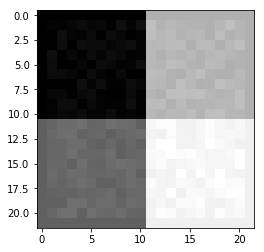

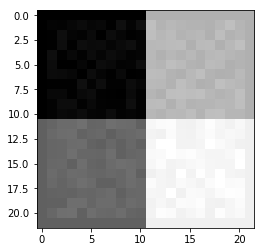

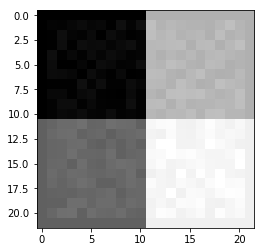

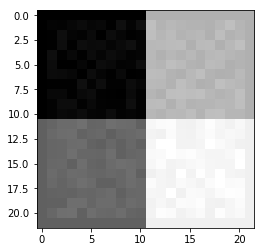

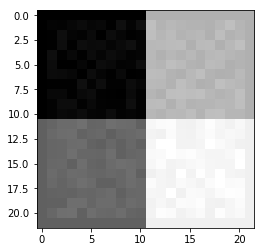

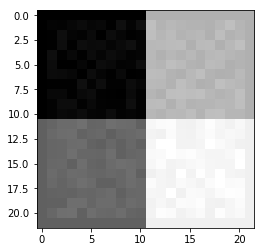

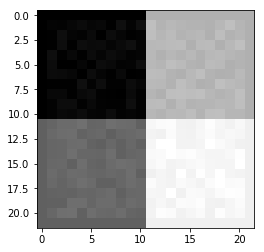

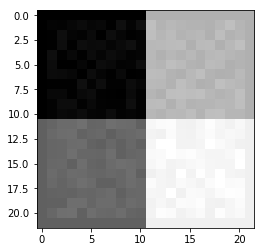

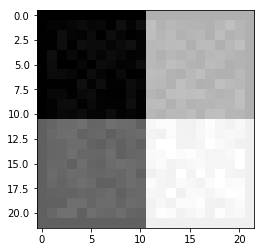

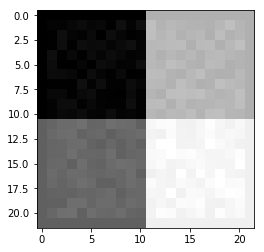

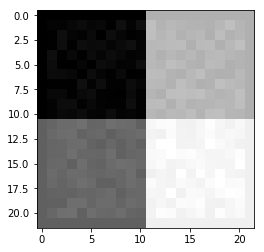

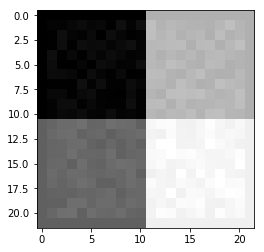

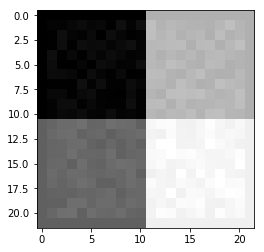

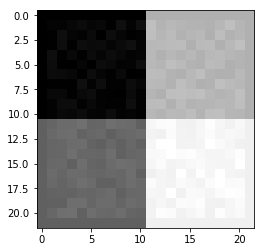

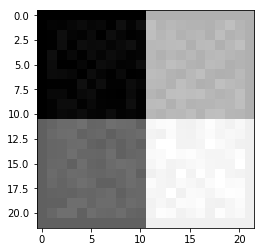

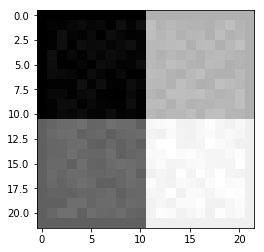

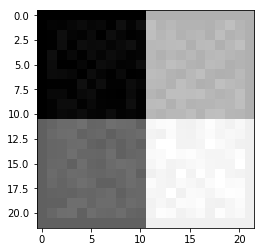

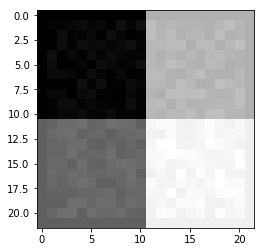

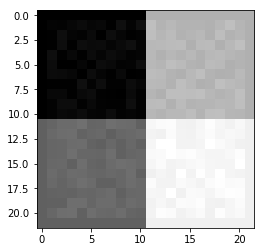

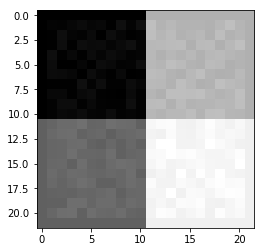

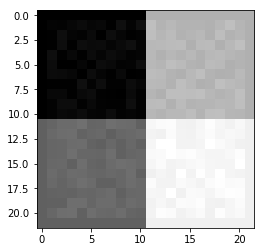

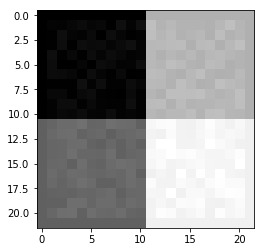

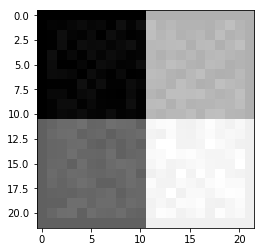

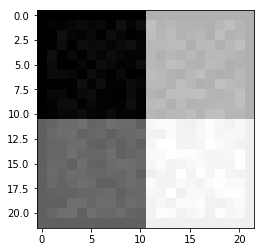

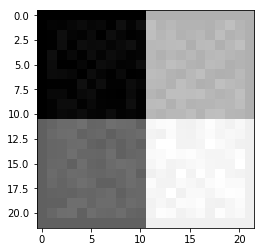

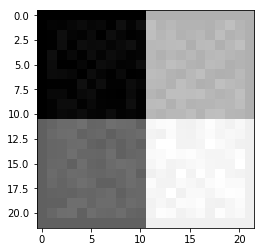

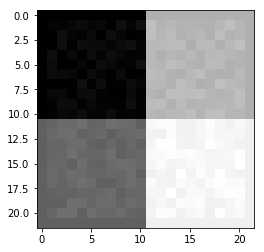

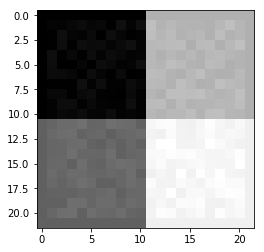

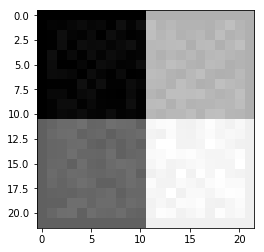

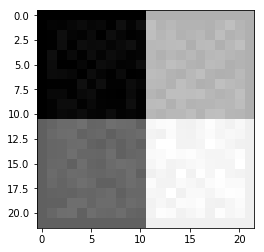

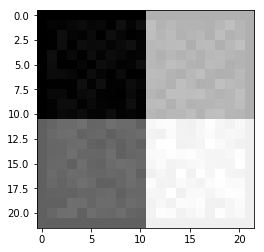

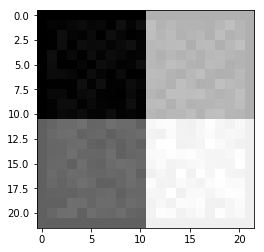

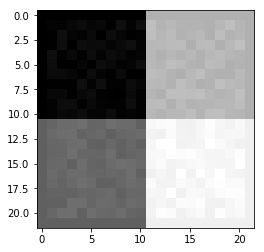

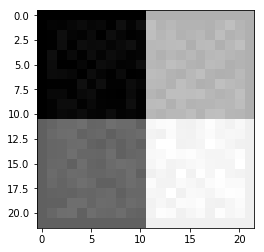

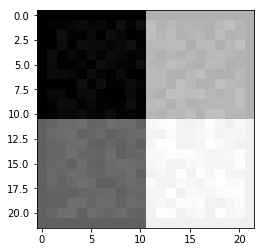

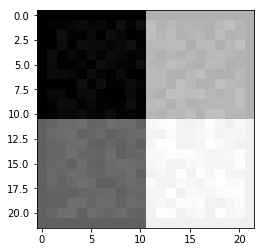

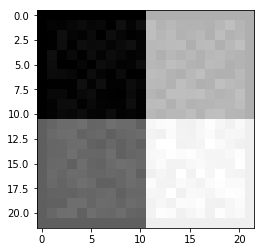

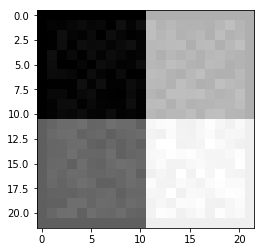

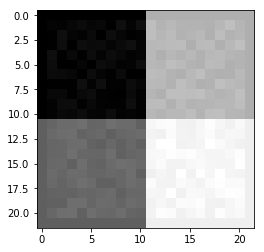

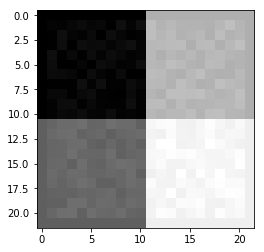

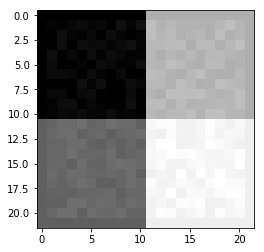

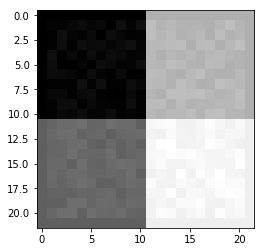

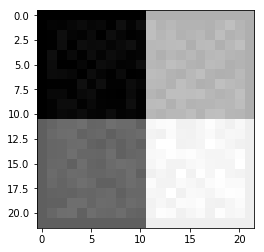

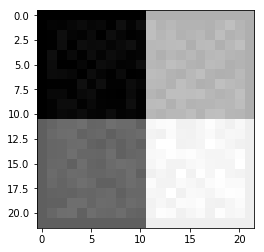

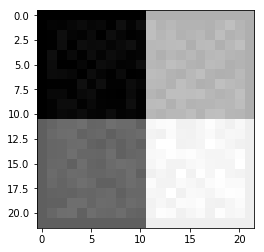

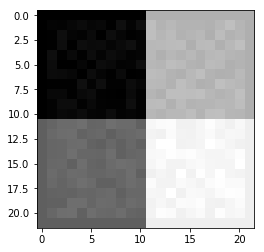

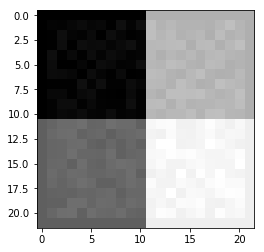

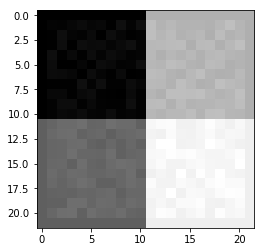

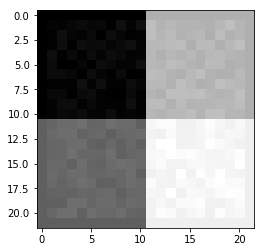

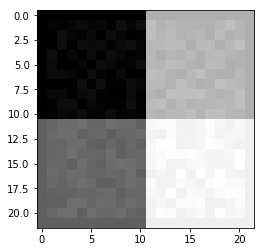

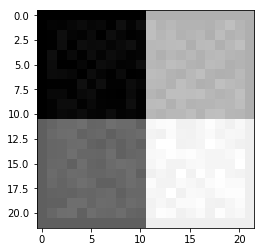

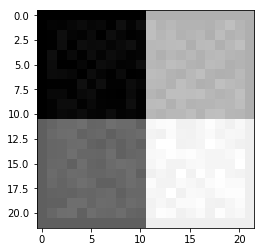

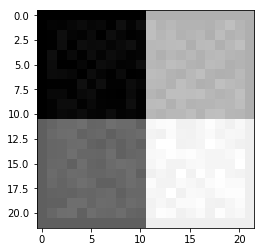

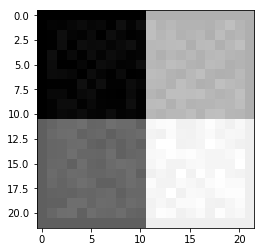

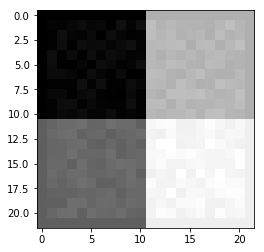

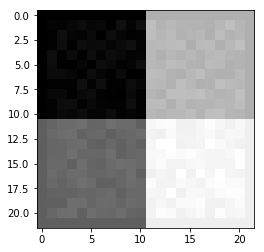

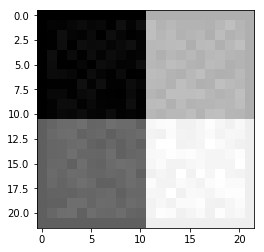

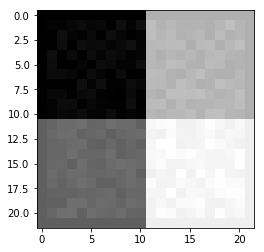

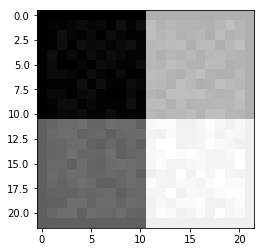

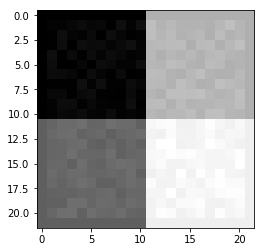

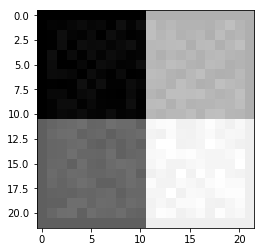

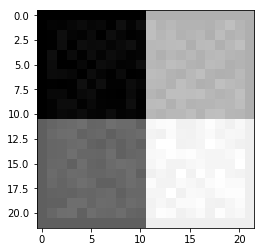

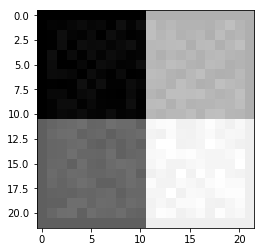

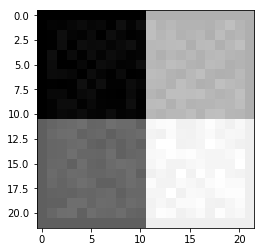

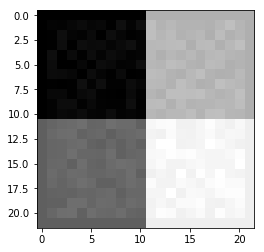

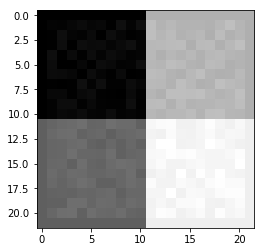

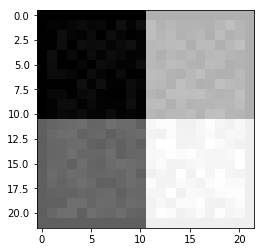

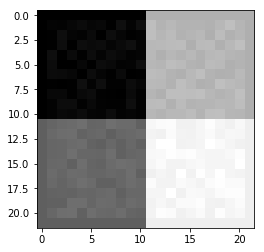

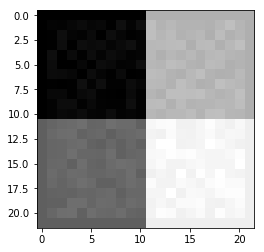

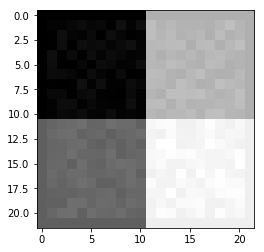

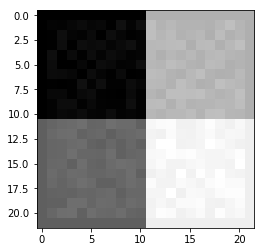

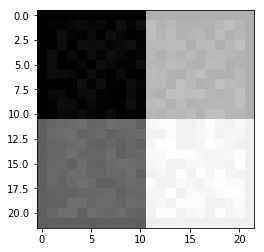

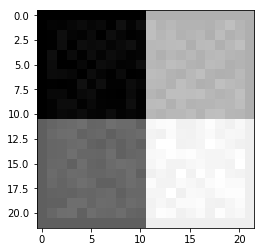

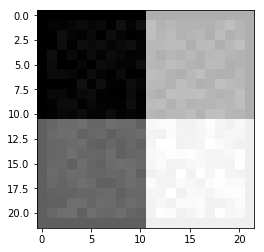

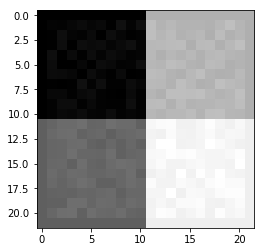

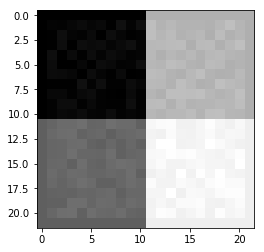

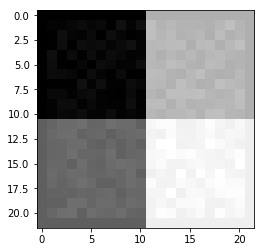

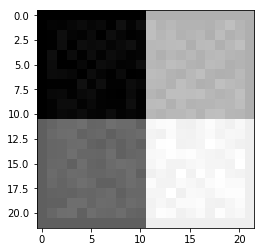

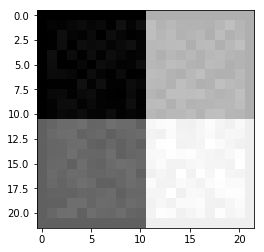

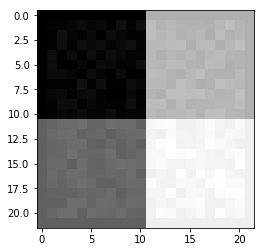

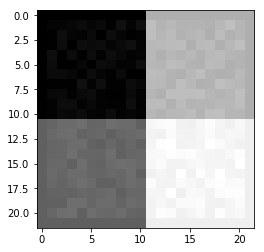

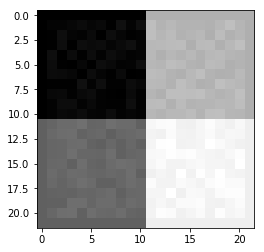

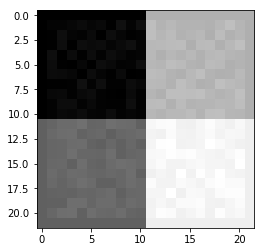

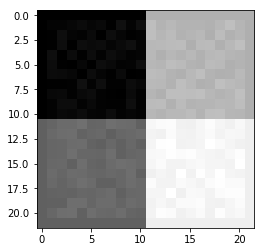

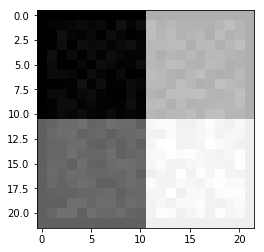

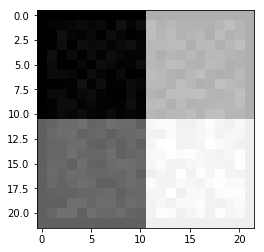

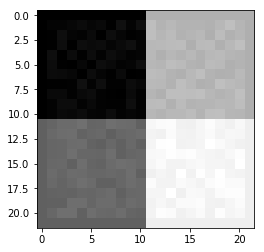

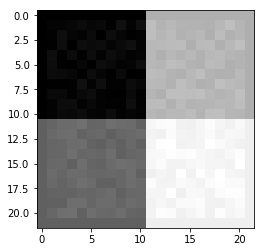

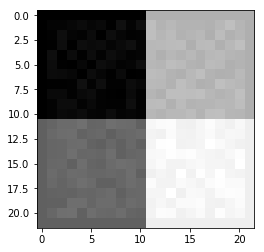

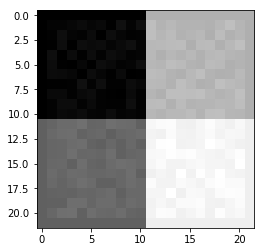

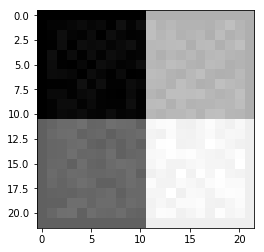

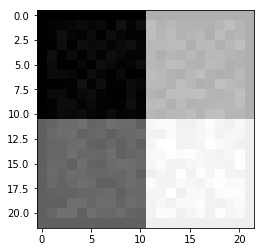

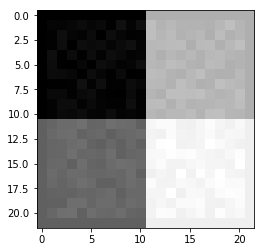

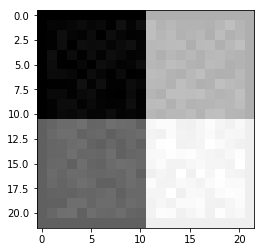

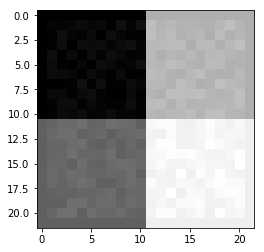

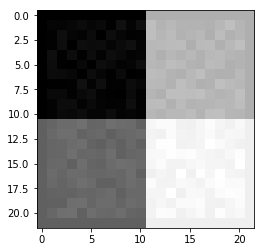

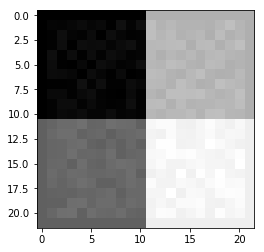

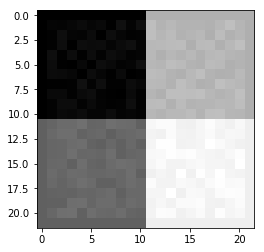

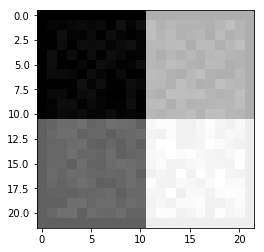

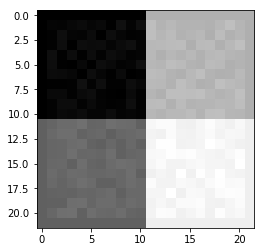

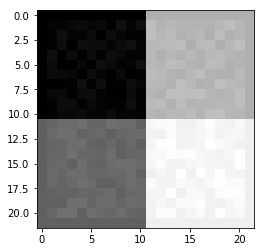

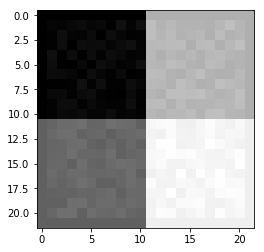

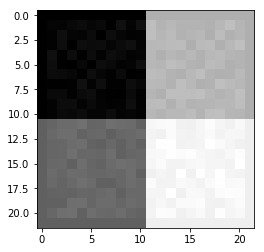

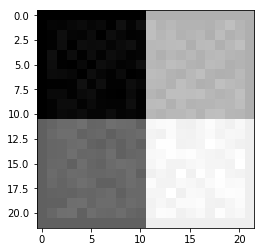

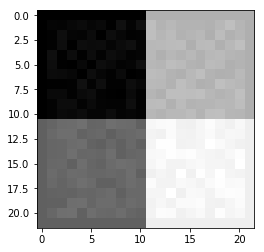

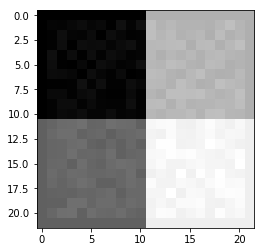

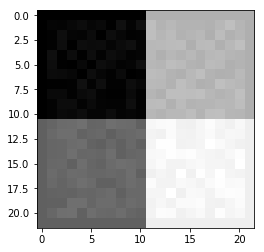

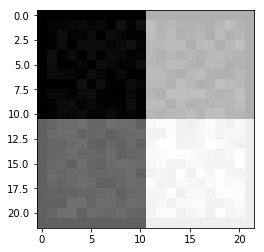

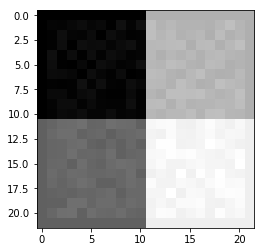

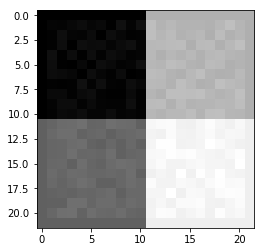

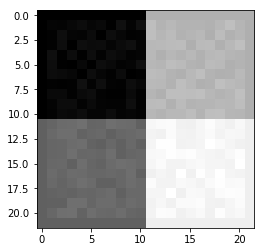

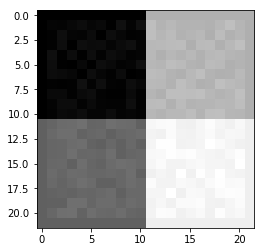

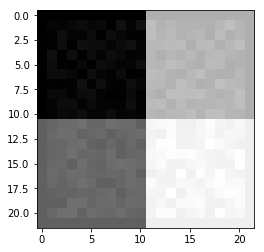

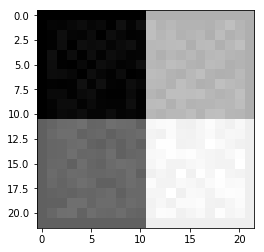

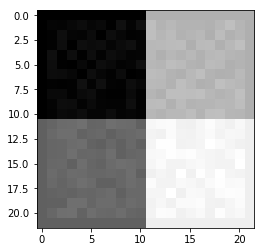

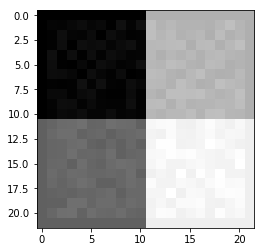

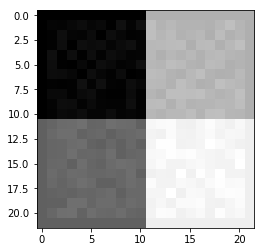

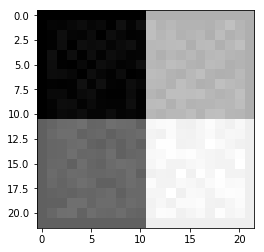

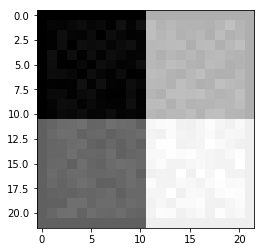

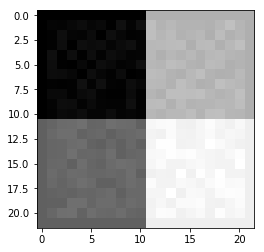

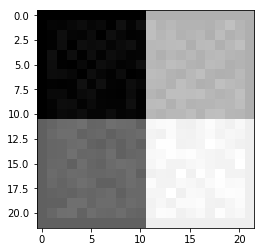

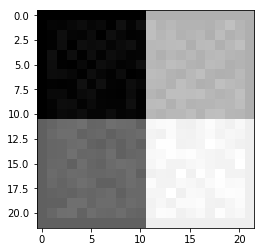

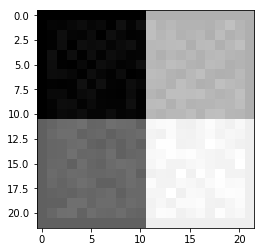

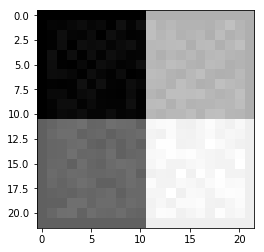

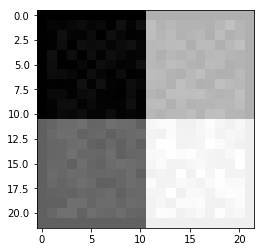

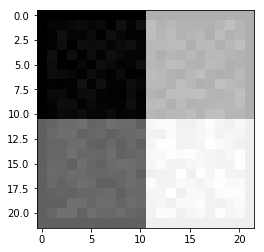

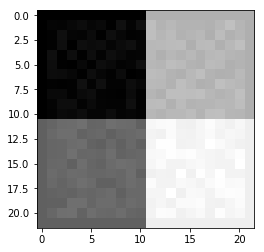

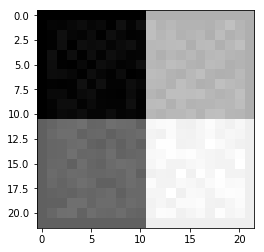

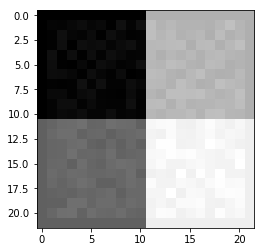

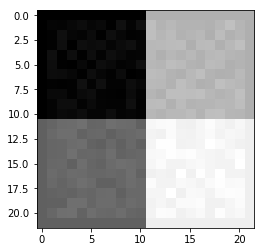

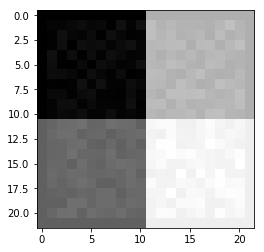

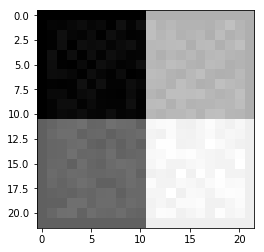

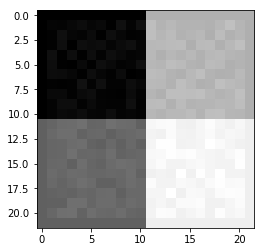

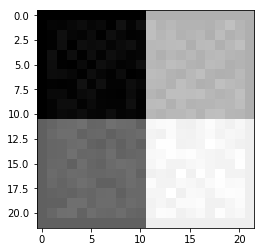

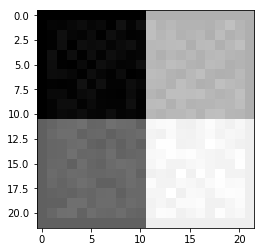

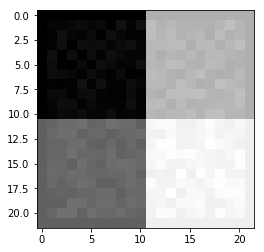

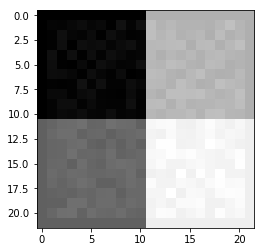

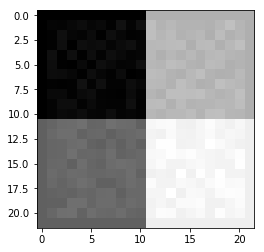

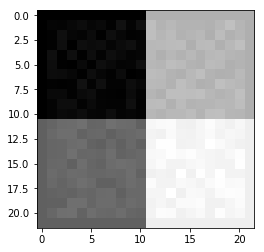

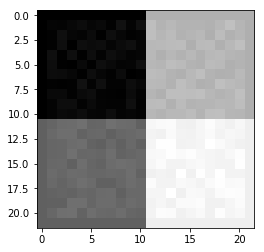

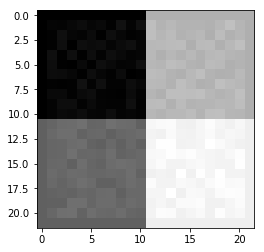

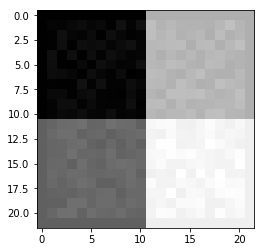

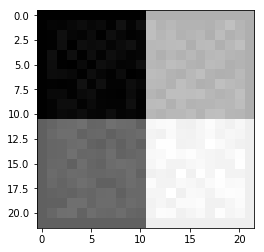

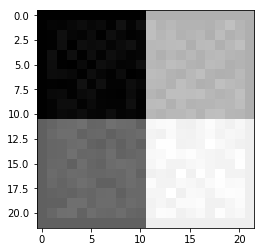

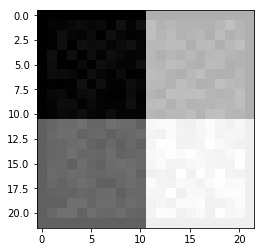

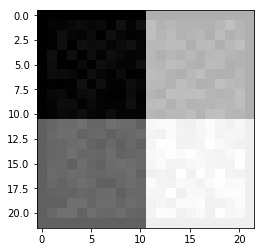

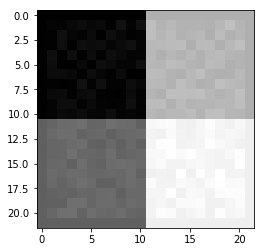

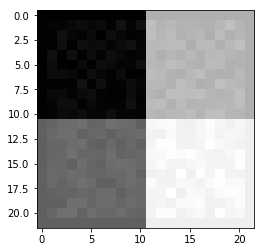

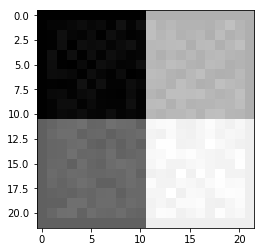

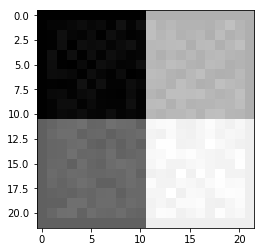

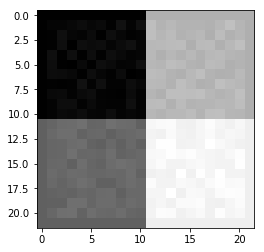

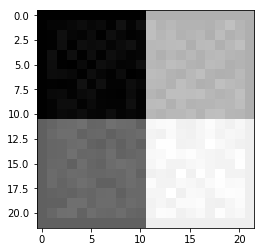

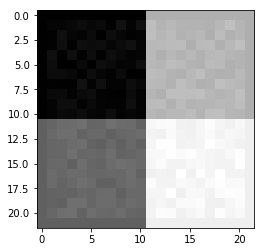

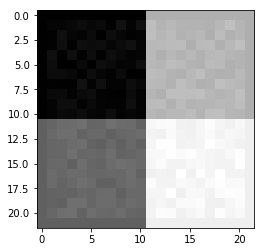

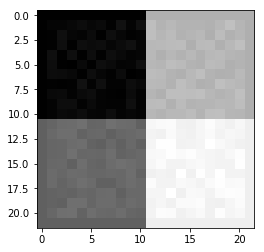

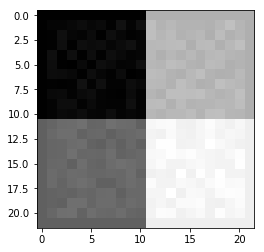

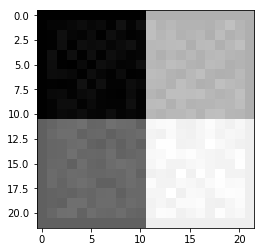

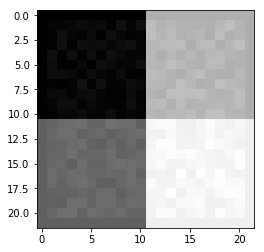

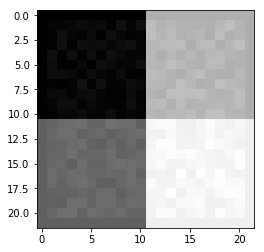

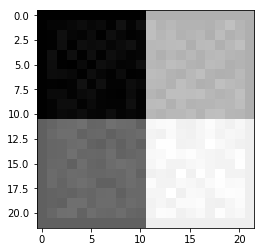

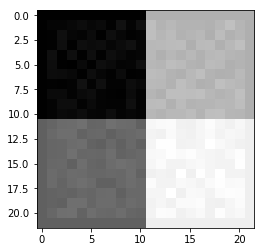

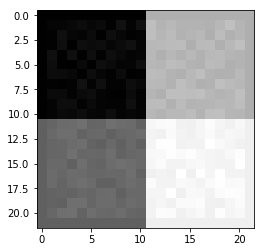

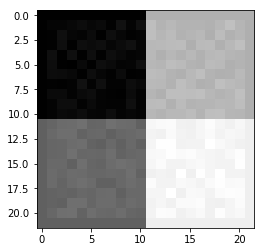

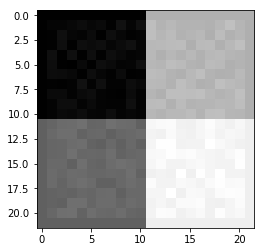

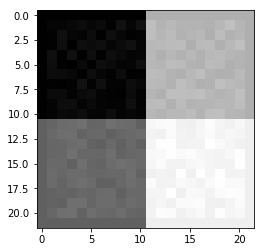

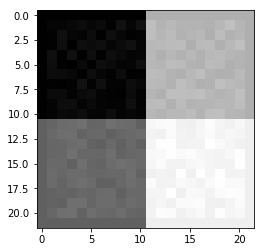

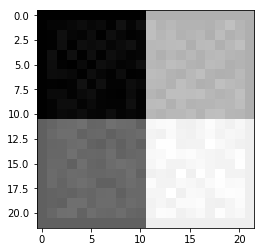

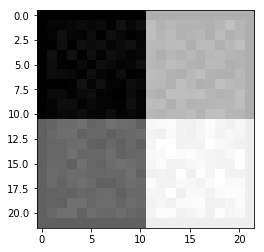

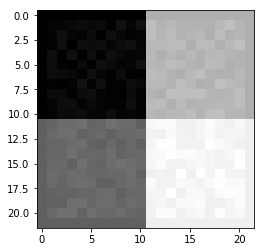

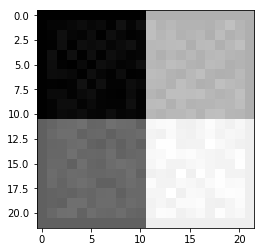

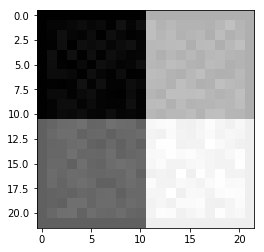

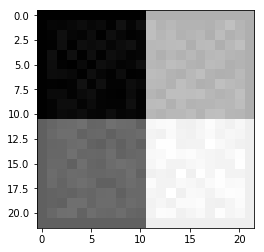

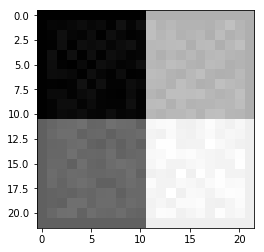

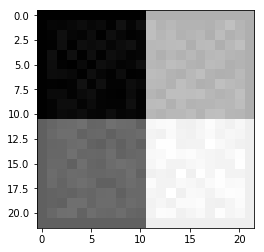

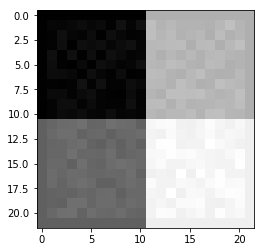

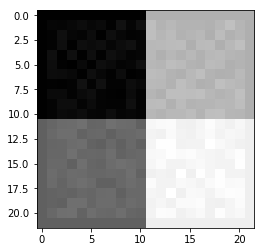

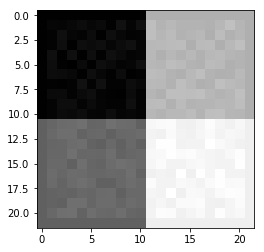

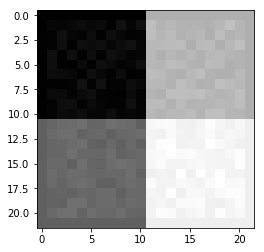

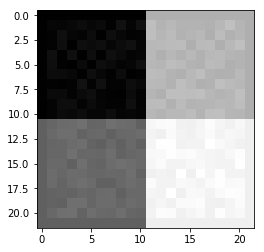

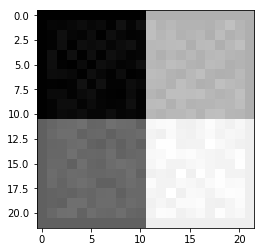

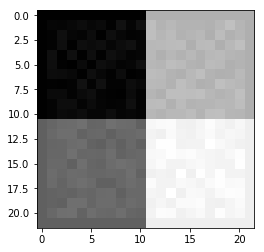

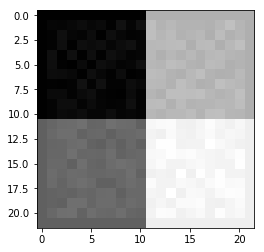

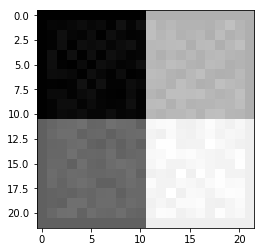

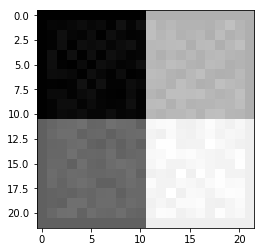

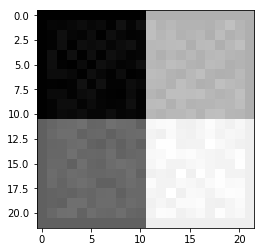

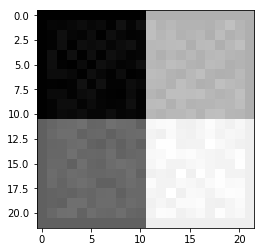

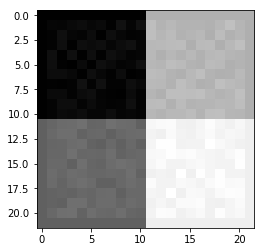

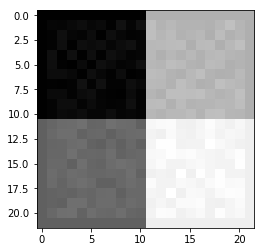

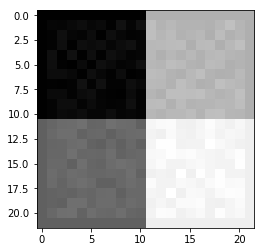

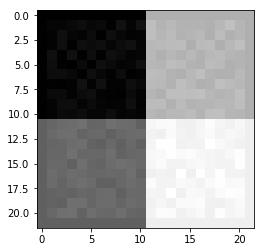

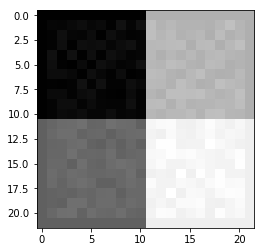

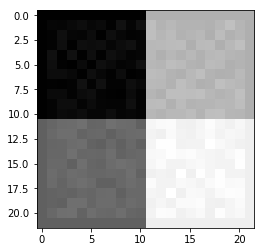

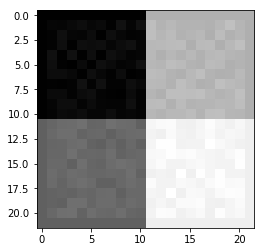

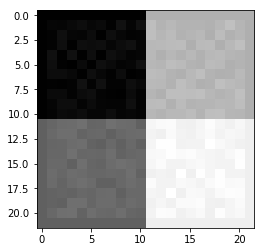

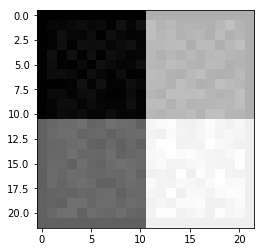

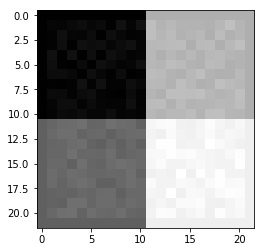

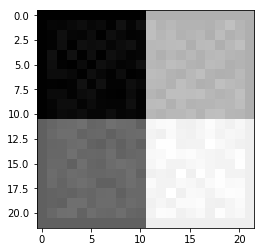

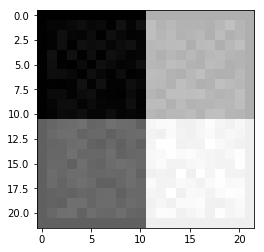

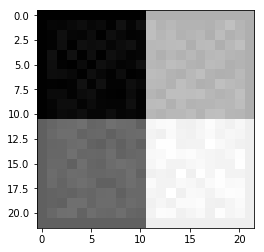

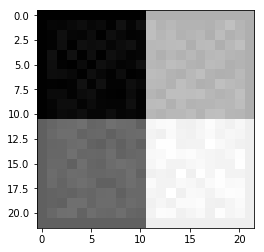

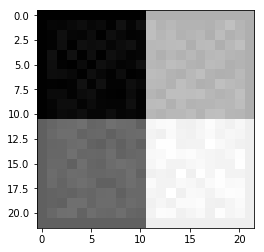

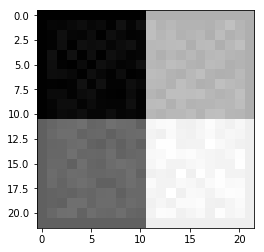

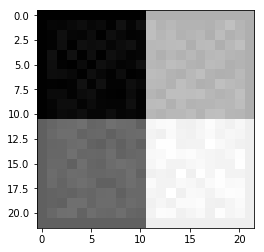

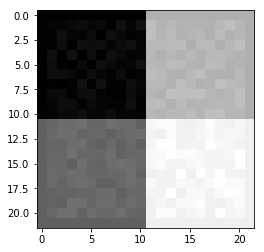

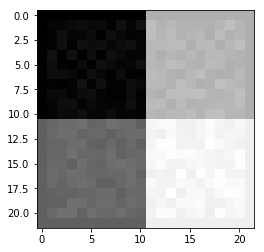

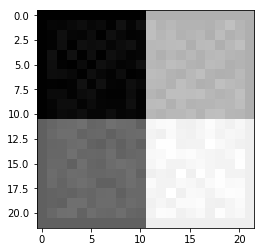

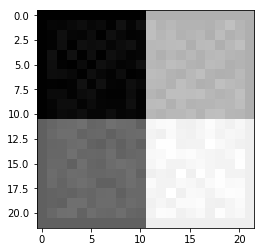

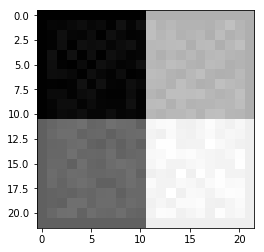

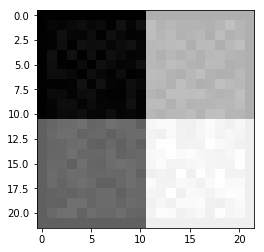

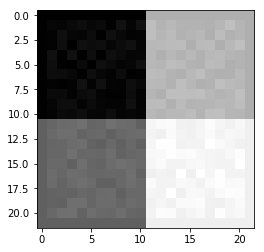

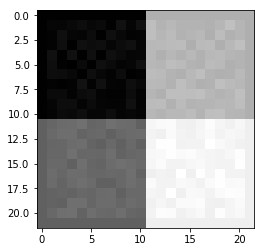

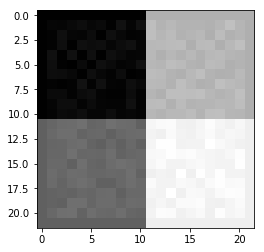

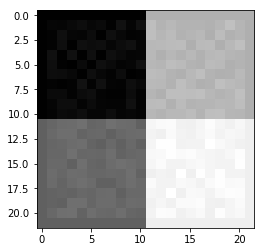

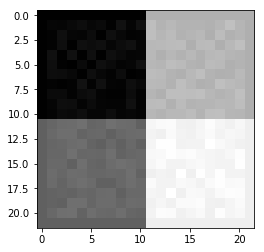

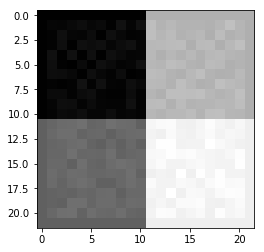

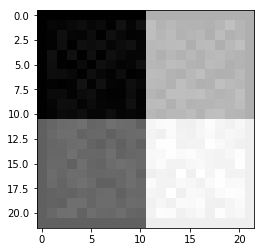

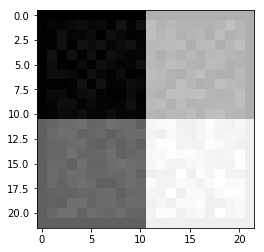

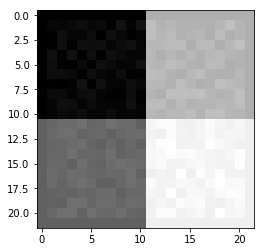

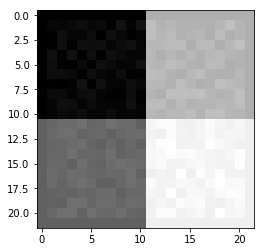

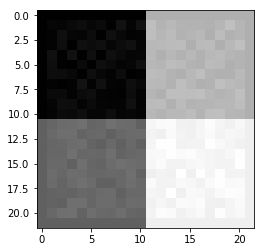

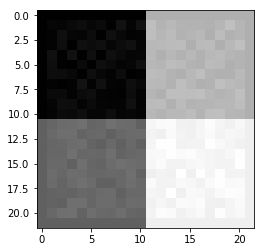

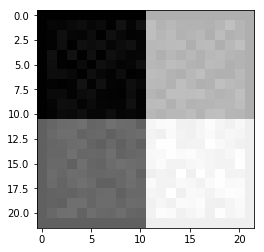

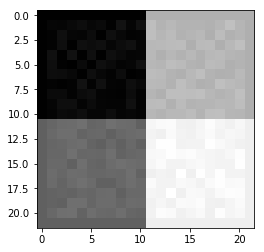

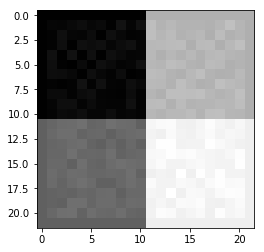

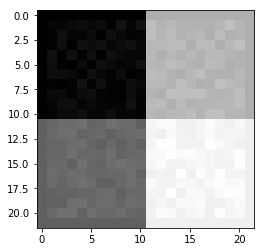

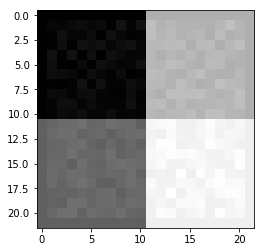

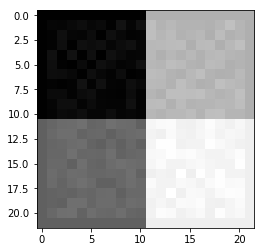

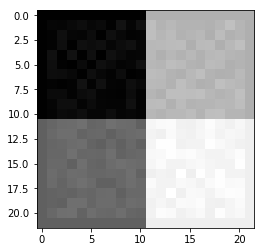

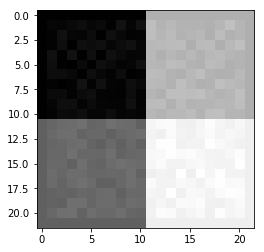

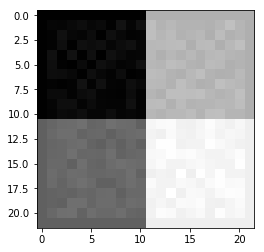

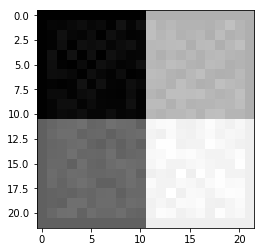

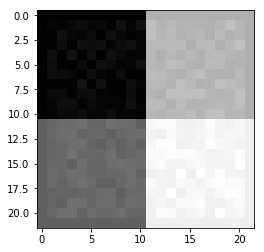

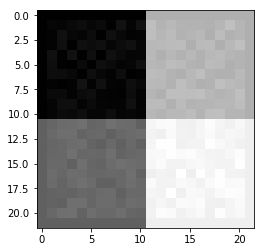

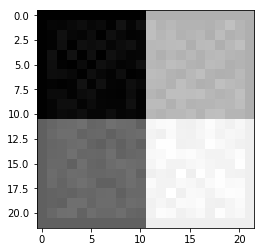

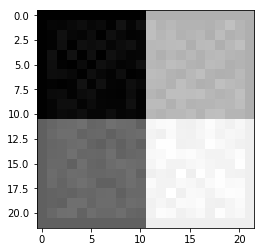

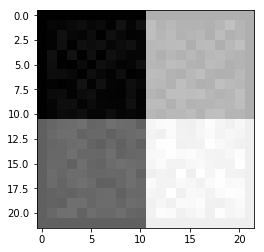

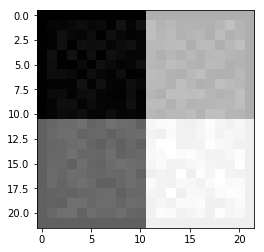

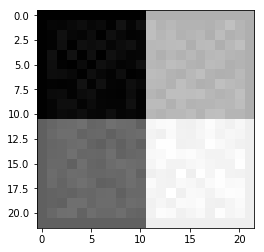

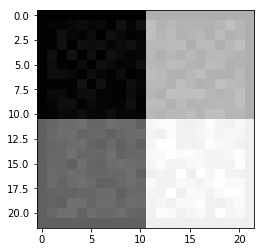

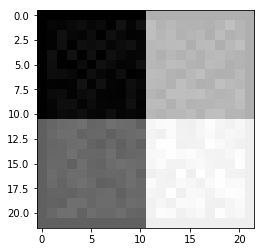

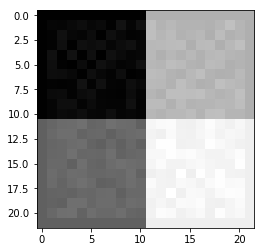

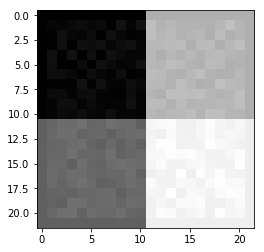

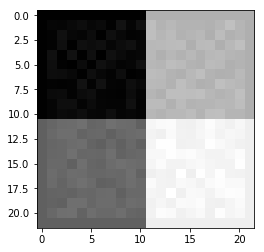

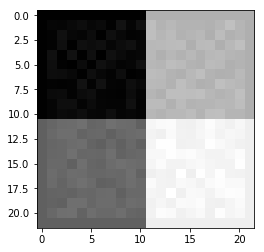

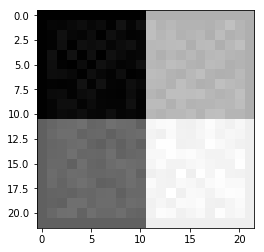

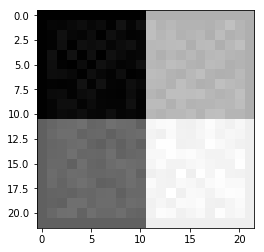

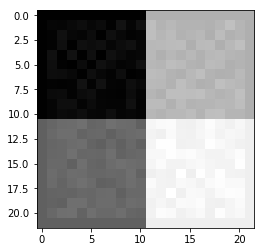

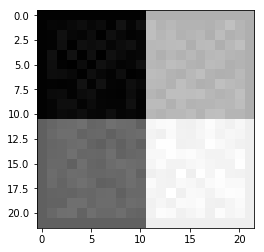

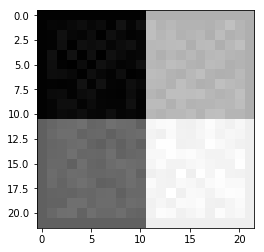

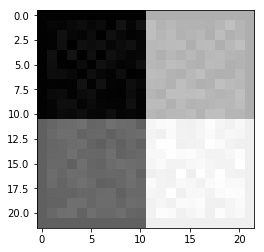

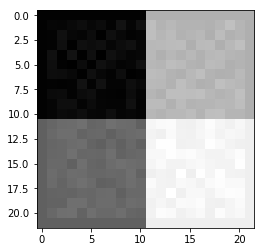

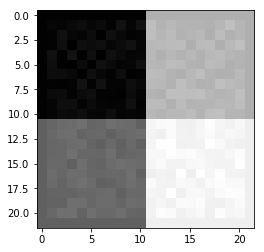

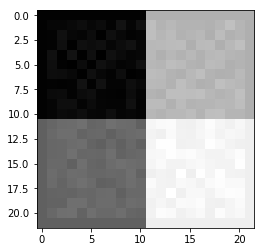

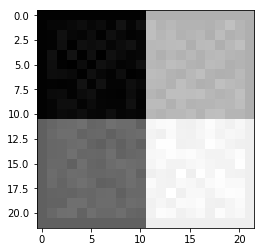

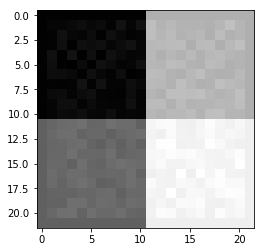

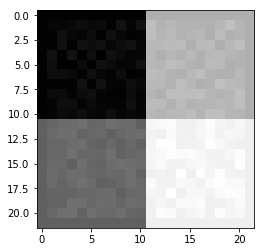

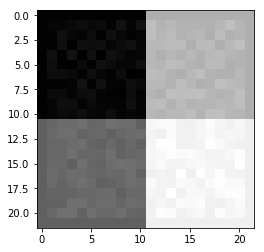

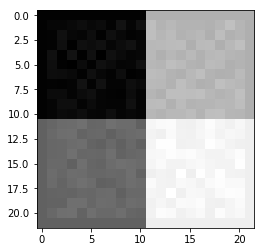

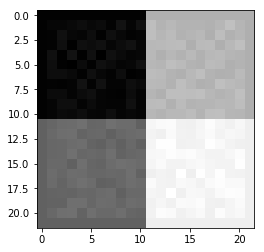

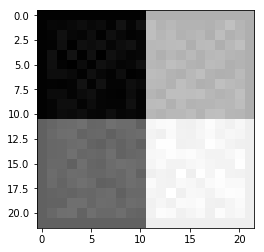

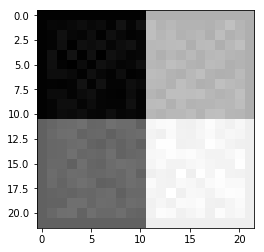

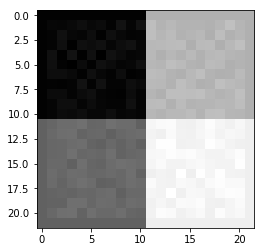

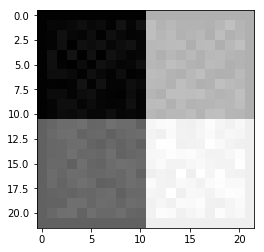

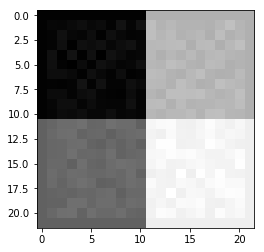

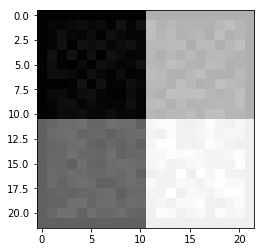

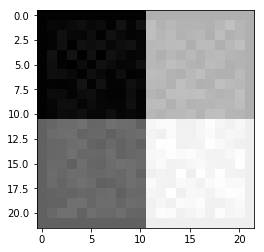

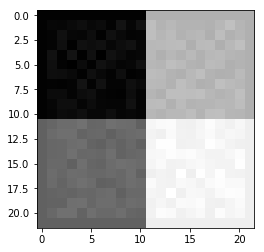

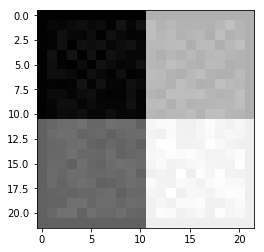

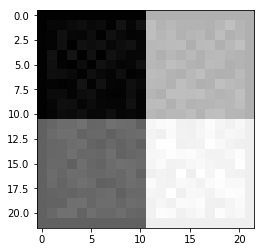

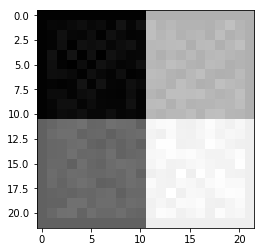

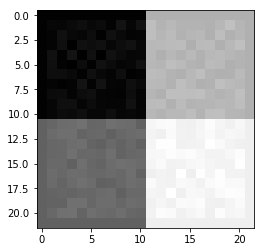

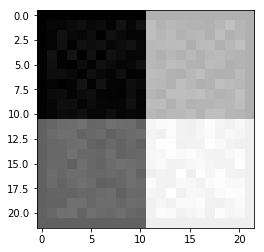

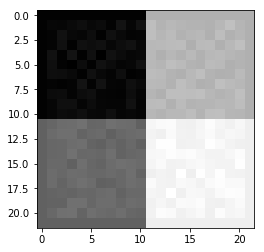

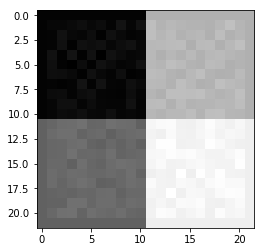

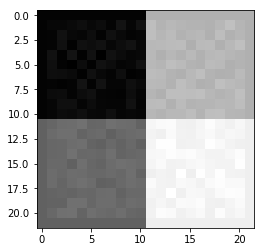

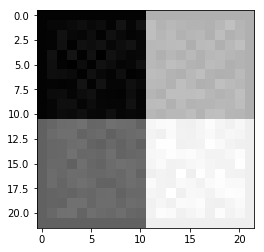

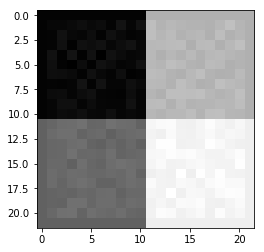

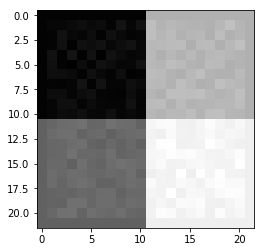

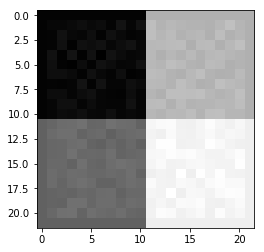

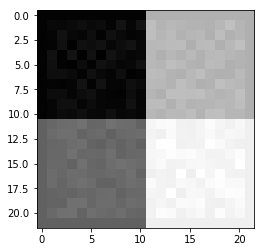

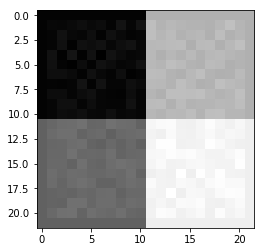

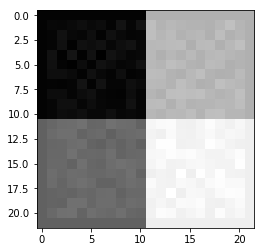

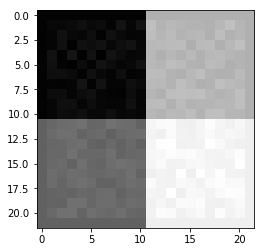

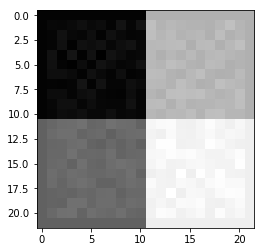

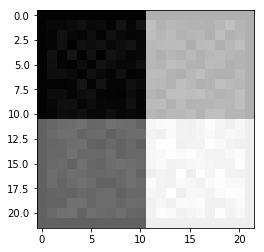

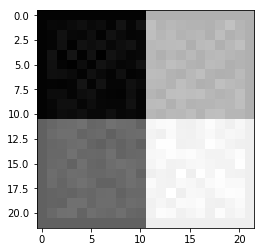

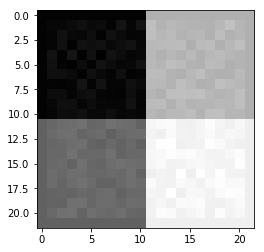

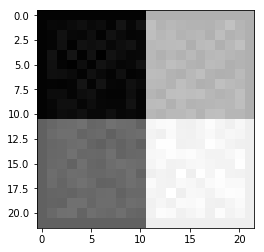

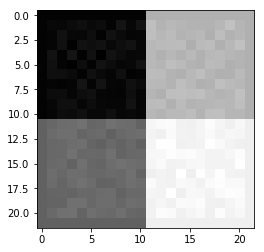

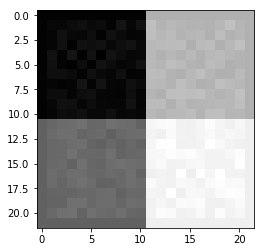

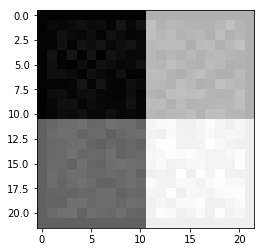

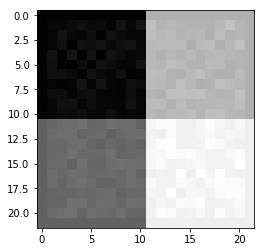

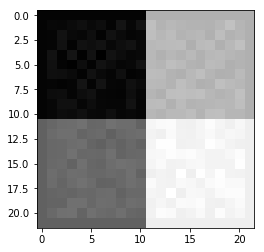

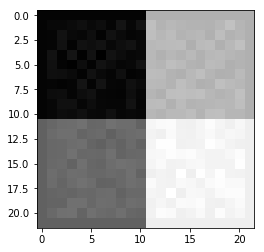

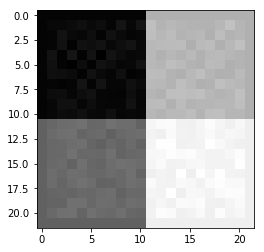

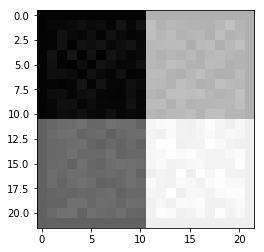

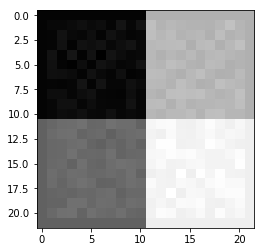

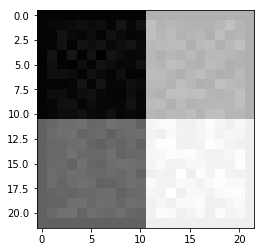

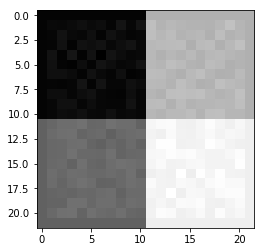

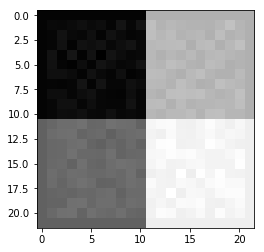

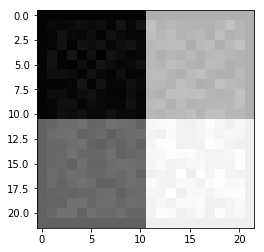

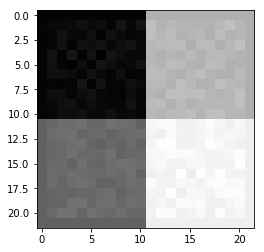

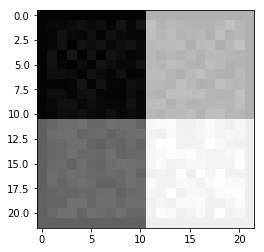

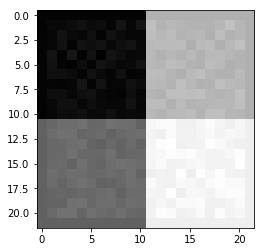

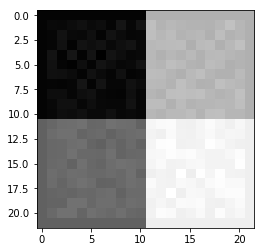

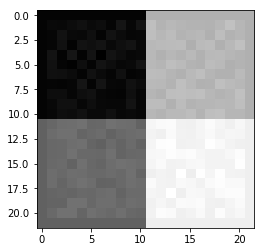

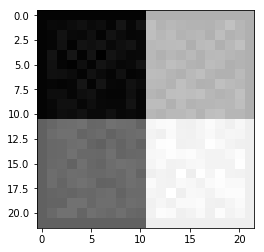

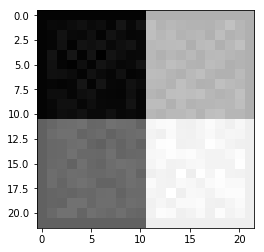

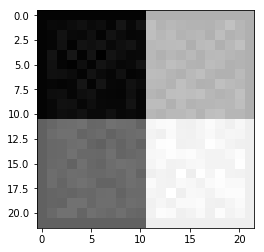

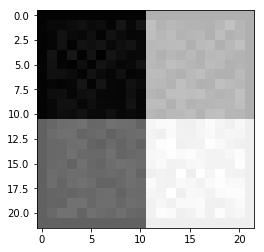

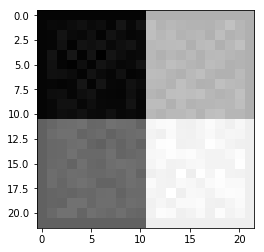

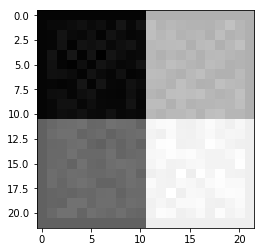

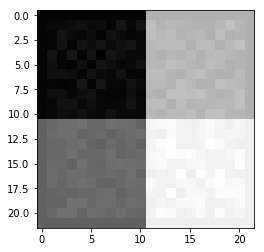

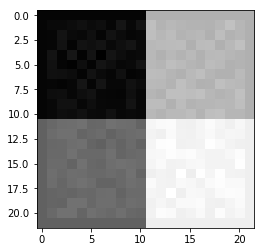

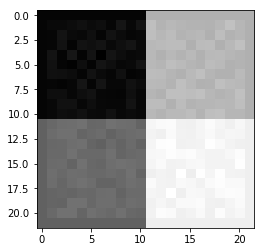

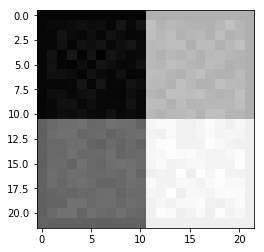

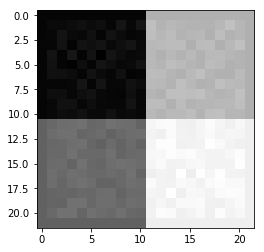

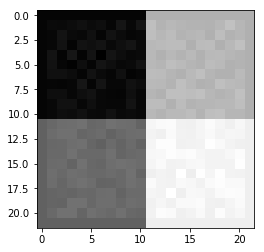

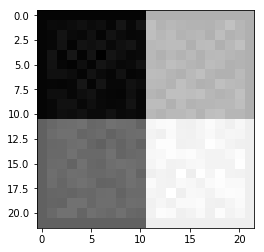

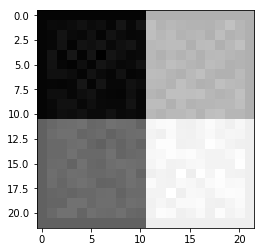

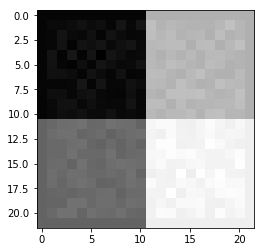

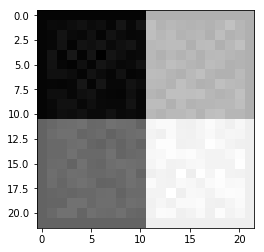

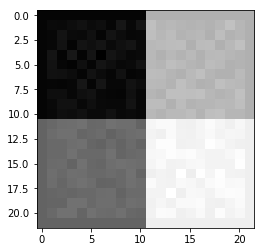

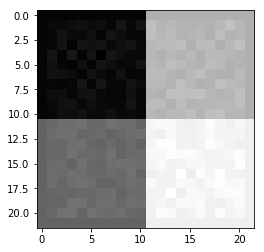

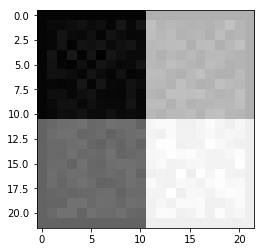

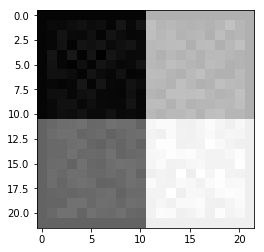

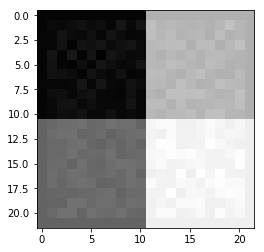

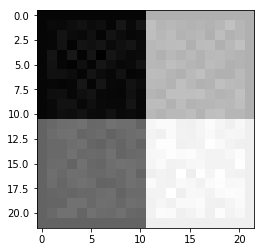

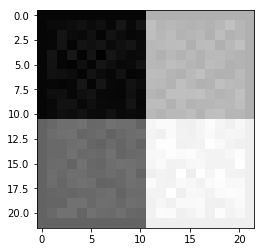

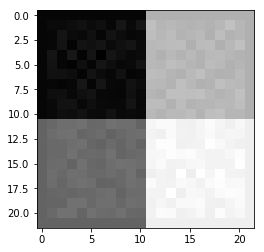

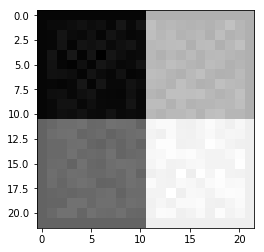

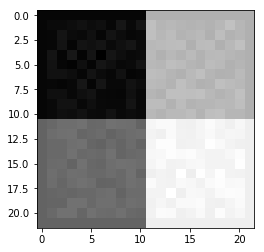

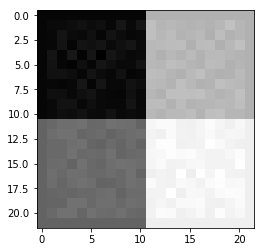

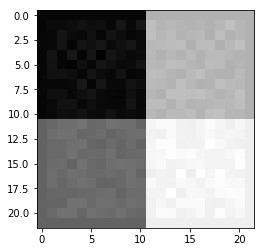

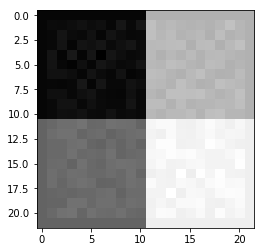

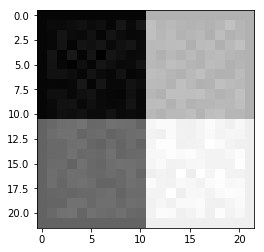

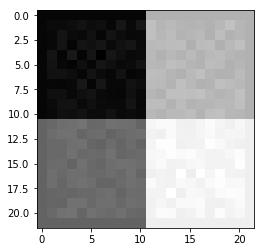

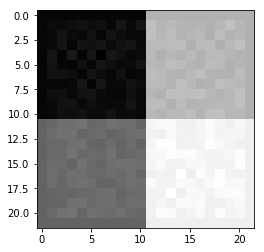

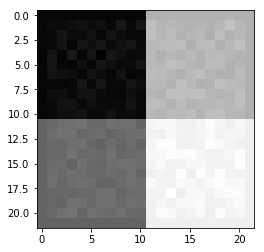

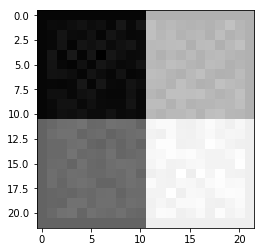

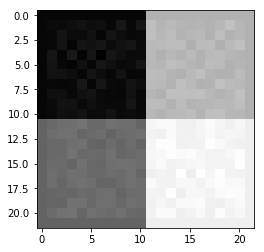

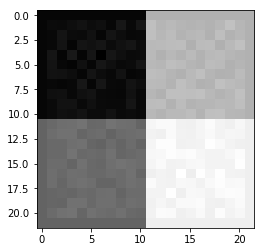

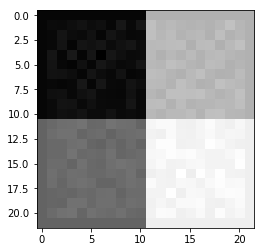

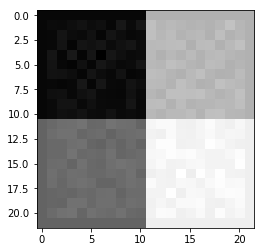

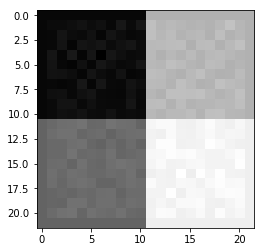

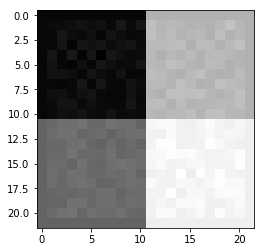

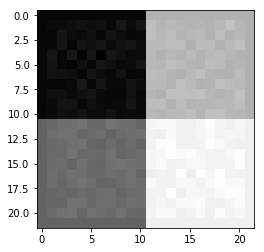

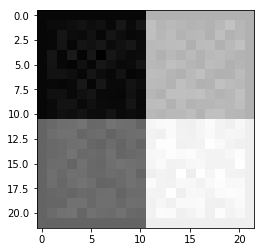

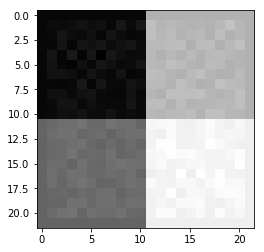

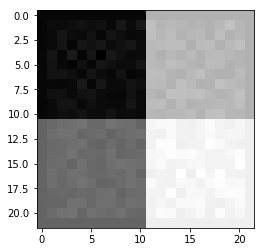

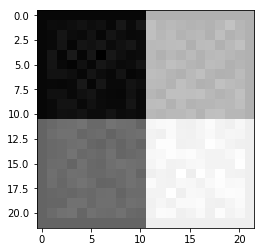

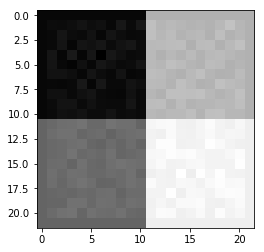

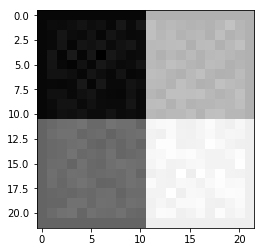

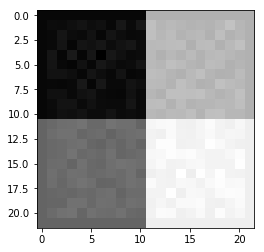

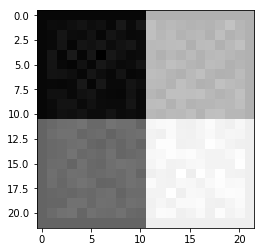

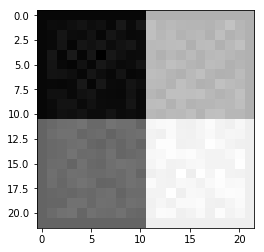

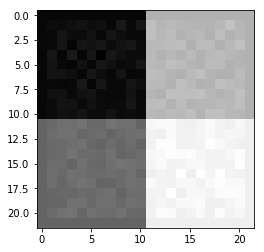

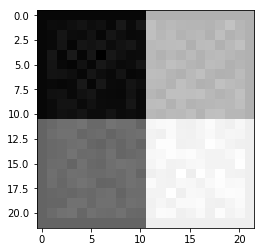

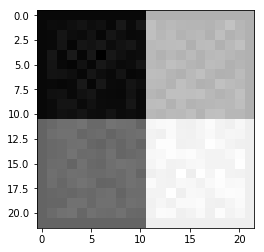

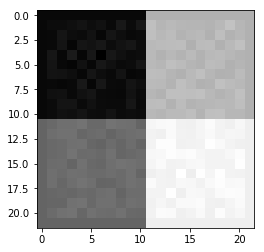

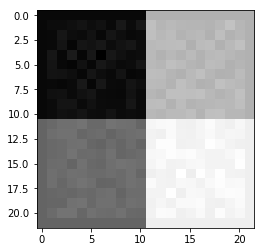

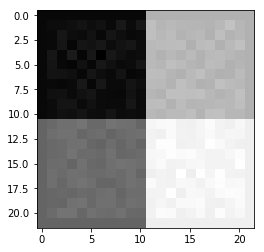

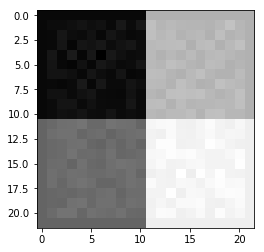

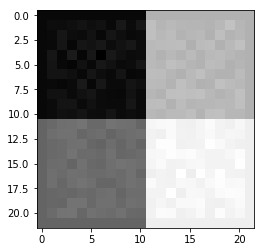

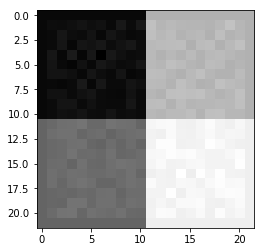

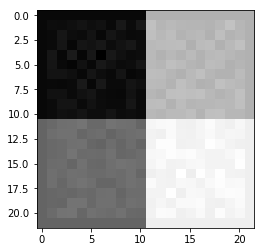

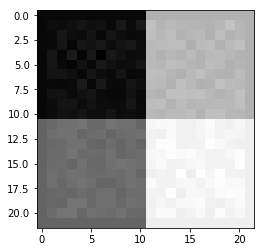

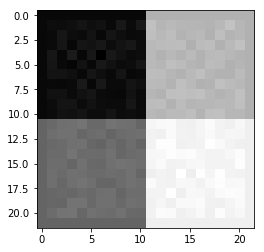

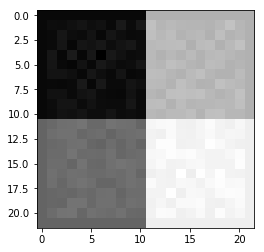

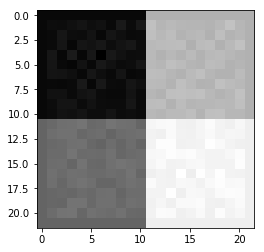

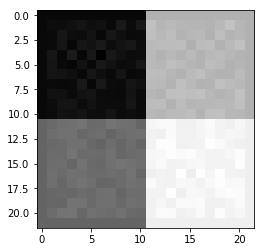

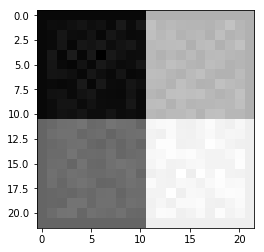

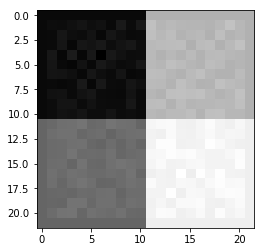

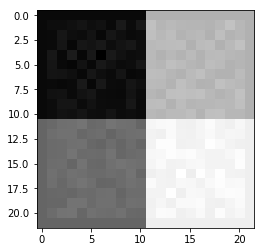

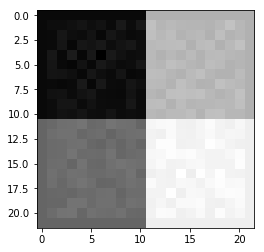

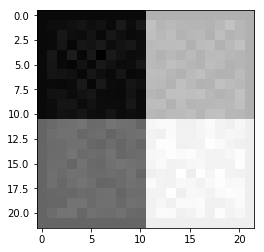

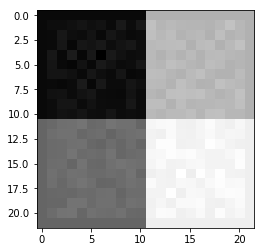

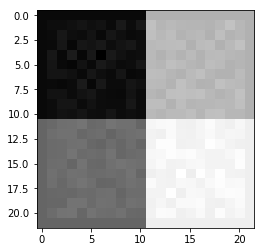

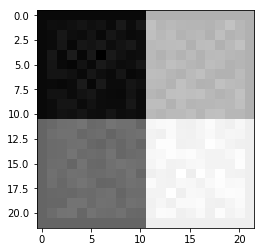

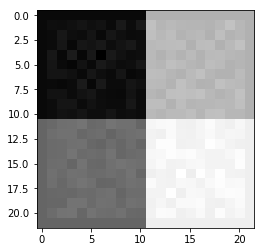

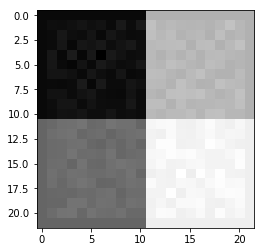

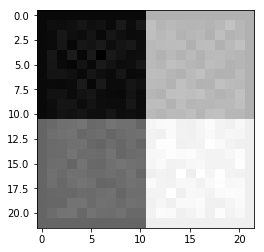

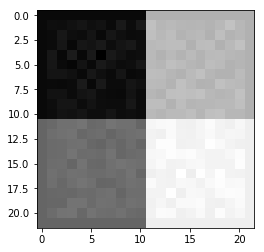

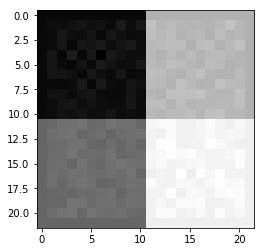

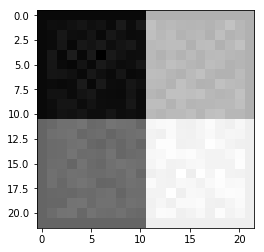

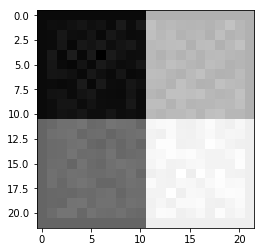

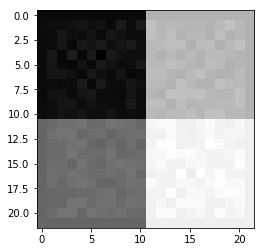

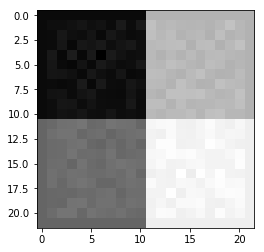

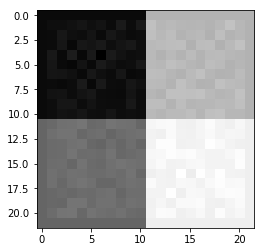

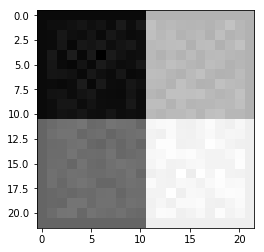

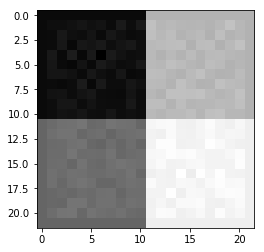

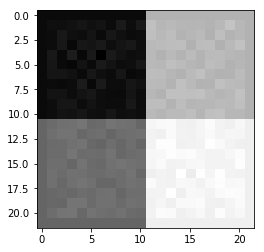

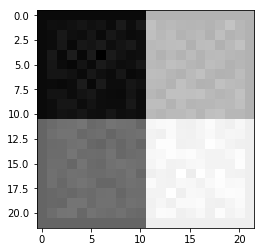

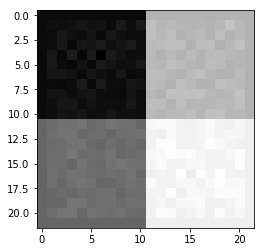

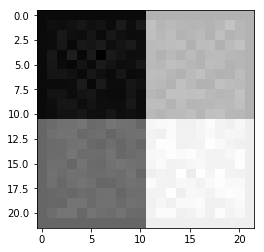

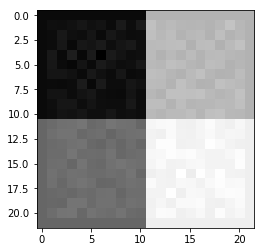

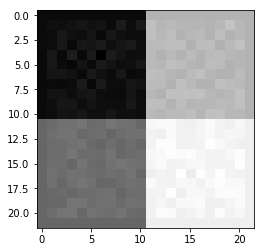

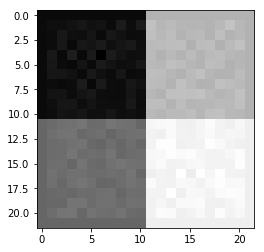

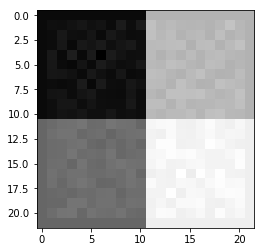

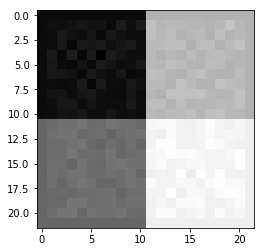

In [156]:
for i in range(0, T-1, 10):
    plt.figure()
    plt.imshow(U[i].reshape(N+2, M+2), cmap = "gray")
    plt.show()

In [157]:
U[-1]-U[0]

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   1.07834803e-01,
         3.85529542e-01,  -1.70628100e-02,   3.27559420e-01,
        -9.58407199e-02,   2.29473581e-01,  -1.40610116e-01,
         7.56454819e-01,  -9.13306632e-01,   5.51581013e-01,
         1.80720196e-02,  -2.73465314e-02,   1.83348082e-02,
         3.25910625e-02,  -8.34953352e-03,   5.27467264e-02,
        -7.57184430e-02,  -1.64792353e-01,   1.36480381e+00,
        -2.57068165e-01,   0.00000000e+00,   0.00000000e+00,
        -4.54304589e-02,   7.03358921e-02,   1.16599050e-04,
        -2.29250858e-01,